In [4]:
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [97]:
from typing import (
    Any,
    Callable,
    Dict,
    Hashable,
    List,
    Mapping,
    Optional,
    Sequence,
    Union,
)
from imitation.data import types

def process_trajectory(data):
    from imitation.data.types import Trajectory
    acts = data.pop('action')[:-1]
    obs = []
    for key, value in data.items():
        obs.append(value)
    obs = np.concatenate(obs, axis=1)
    return Trajectory(obs, acts, None, terminal=True)



def process_image_transitions(trial_path: str, images: bool = False):
    from imitation.data.rollout import flatten_trajectories
    from matplotlib import pyplot as plt
    trial_path = Path(trial_path)
    trajectories = []
    for episode_path in trial_path.iterdir():
        trajectory = {}
        data = np.load(episode_path / "trajectory.npz", allow_pickle=True)
        data = dict(data)
        trajectory['action'] = data['action']
        trajectory.setdefault('pixels', [])
        images_path = episode_path / "images"
        for image_path in images_path.iterdir():
            image = plt.imread(image_path)[:, :, 0]
            image = image * 255
            image = image.astype(np.uint8)
            # image = np.expand_dims(image, axis=0)
            trajectory['pixels'].append(image)
        trajectories.append(process_trajectory(trajectory))
    transitions = flatten_trajectories(trajectories)
    print(
        f'Processed {len(trajectories)} trajectories ({len(transitions)} transitions)')
    trajectory_lengths = [len(traj) for traj in trajectories]
    print('mean trajectory length:', np.mean(trajectory_lengths))

    return transitions


In [98]:
transitions_path = Path.cwd() / 'expert' / 'trial_1'
transitions = process_image_transitions(transitions_path, images=True)
print(transitions[0]['obs'].shape, transitions[0]['obs'].max(), transitions[0]['obs'].min())

Processed 22 trajectories (2440 transitions)
mean trajectory length: 110.9090909090909
(480, 480) 253 30


In [99]:
# create a dataloader for this transitions dataset

class TransitionsData(torch.utils.data.Dataset):

    def __init__(self, transitions, transforms=None):
        self.transforms = transforms
        self.transitions = transitions

    def __len__(self):
        return len(self.transitions)

    def __getitem__(self, idx):
        X = self.transitions[idx]['obs']
        X  = np.stack([X,X,X], axis=-1)
        y = self.transitions[idx]['acts']
        if self.transforms:
            X = self.transforms(X)
        return X, y

In [103]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
#  Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((224, 224),interpolation=InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
                            
])


dataset = TransitionsData(transitions, transforms=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
images, labels = next(iter(loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 2])


(-0.5, 223.5, 223.5, -0.5)

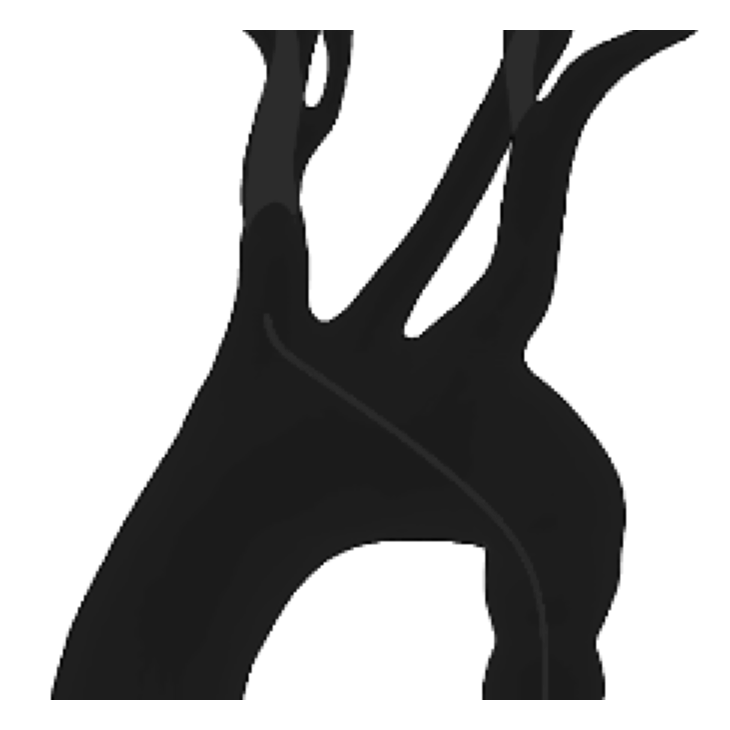

In [104]:
plt.imshow(images[0][0],cmap='gray')
plt.axis('off')

In [105]:
from torchvision.models import ViT_B_16_Weights

# load the model based on VisionTransformer
vit_based = torchvision.models.vision_transformer.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
## freeze the layers
for param in vit_based.parameters():
   param.requires_grad = False

In [46]:
print(vit_based)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [106]:
# load the model based on VisionTransformer
vit_based = torchvision.models.vision_transformer.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
## freeze the layers
for param in vit_based.parameters():
   param.requires_grad = False


# Modify the last layer to fit the action space
number_features = vit_based.heads.head.in_features
features = list(vit_based.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 2)])
# add a tanh layer to make the output in the range of [-1,1]
features.extend([torch.nn.Tanh()])
vit_based = torch.nn.Sequential(*features)

vit_based = vit_based.to('cuda')


print(vit_based)

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadA

In [107]:
# train the model
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(vit_based.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for X, y in loader:
        X = X.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        outputs = vit_based(X)
        print(outputs.shape, y.shape)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

AssertionError: Expected (batch_size, seq_length, hidden_dim) got torch.Size([32, 768, 14, 14])